# ProSup DTM Binary Movement Classifier

In [1]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load

In [44]:
def filter_df(files_df,order=1,cf=50,fs=2000):
    b,a = signal.butter(1, 50,fs=fs)
    for i in range(len(files_df)):
        emg_df = pd.DataFrame(columns=emg_labels)
        for labels in emg_labels:
            emg_df[labels] = signal.lfilter(b, a,files_df[i][labels])
        files_df[i][emg_labels] = np.array(emg_df)
    return files_df
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']

## Generate File Names

### Pronation Supination Files

In [45]:
prosup_files = []
dtm_files = []
subjects = ['Fazil/day_04_24_21','Nikhil/day_05_13_21'] #'Fazil/day_04_14_21'

In [46]:
for subj in subjects:
    path = 'Subjects/'+subj
    # trial_names = ['Bulb','Hammer'] # 'Bulb','Hammer' ,'Cup','Screw'
    trial_names = ['Bulb','Screw'] #,
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                prosup_files.append(path+'/computed_'+exp+'.csv')
            else:
                prosup_files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
prosup_files

['Subjects/Fazil/day_04_24_21/computed_Bulb.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Screw.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Screw01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Screw02.csv']

In [47]:
prosup_files_df = []
for file in prosup_files:
    prosup_files_df.append(pd.read_csv(file,index_col=0))
prosup_files_df = filter_df(prosup_files_df)

### DTM Files

In [25]:
for subj in subjects:
    path = 'Subjects/'+subj
    # trial_names = ['Bulb','Hammer'] # 'Bulb','Hammer' ,'Cup','Screw'
    trial_names = ['Hammer','Cup'] #,
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                dtm_files.append(path+'/computed_'+exp+'.csv')
            else:
                dtm_files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
dtm_files

['Subjects/Fazil/day_04_24_21/computed_Hammer.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup02.csv']

In [26]:
dtm_files_df = []
for file in dtm_files:
    dtm_files_df.append(pd.read_csv(file,index_col=0))
dtm_files_df = filter_df(dtm_files_df)

## Dataset Preparation

In [27]:
window = 250
interval = 15
Normalize = False
rms = False
angle_thresh_DTM = 0.008
angle_thresh_prosup = 0.001

In [28]:
X_prosup, y_prosup = multiple_prep_data_DTM(prosup_files_df,
                                      window,
                                      interval,
                                      Normalize,
                                      rms,
                                      angle_thresh_prosup)
print(X_prosup.shape,y_prosup.shape)


(58206, 250, 8) (58206, 3)


In [29]:
X_dtm, y_dtm = multiple_prep_data_DTM(dtm_files_df,
                                      window,
                                      interval,
                                      Normalize,
                                      rms,
                                      angle_thresh_DTM)
print(X_dtm.shape,y_dtm.shape)


(43008, 250, 8) (43008, 3)


## Merge ProSup and DTM Datasets to Bianry excluding Rest Labels

In [30]:
X_dtm_n = []
for i in tqdm(range(y_dtm.shape[0])):
    if y_dtm[i][0]!=1:
        X_dtm_n.append(X_dtm[i])
X_dtm_n = np.array(X_dtm_n)        

X_prosup_n = []
for i in tqdm(range(y_prosup.shape[0])):
    if y_prosup[i][0]!=1:
        X_prosup_n.append(X_prosup[i])
X_prosup_n = np.array(X_prosup_n)  

# prosup - 0
# DTM - 1
X = np.vstack((X_prosup_n,X_dtm_n))
a = np.array([[1,0]]*X_prosup_n.shape[0])
b = np.array([[0,1]]*X_dtm_n.shape[0])
y = np.vstack((a,b))

In [31]:
X.shape, y.shape

((71702, 250, 8), (71702, 2))

## Time Window Normalization

In [32]:
def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

X_mean = np.zeros(X[0].shape)
for x in X:
    X_mean = X_mean + x
X_mean = X_mean/X.shape[0]
X_std = np.sqrt(variance(X))
np.save('mean_std',np.array([X_mean,X_std]))

In [33]:
Xn = []
for x in tqdm(X):
    Xn.append((x-X_mean)/X_std)
X = np.array(Xn)

In [34]:
np.save('prepared_data/X_prosup_dtm_tw',X)
np.save('prepared_data/y_prosup_dtm_tw',y)

In [48]:
X = np.load('prepared_data/X_prosup_dtm_tw.npy')
y = np.load('prepared_data/y_prosup_dtm_tw.npy')

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(57361, 250, 8)
(14341, 250, 8)
(57361, 2)
(14341, 2)


In [50]:
y_true = []
for d in y_test:
    idx = list(d).index(1)
    y_true.append(idx)

## Label Distribution

In [51]:
def count(y):
    s0 = 0
    s1 = 0
    for arr in y:
        if arr[0]==1:
            s0 = s0+1
        if arr[1]==1:
            s1 = s1+1
    ls = [s0,s1]
    for i in range(2):
        print(i,'-',ls[i],'[',ls[i]*100/len(y),'%]')

In [52]:
print(count(y_train))
print(count(y_test))

0 - 42430 [ 73.97011907044856 %]
1 - 14931 [ 26.02988092955144 %]
None
0 - 10513 [ 73.30730074611255 %]
1 - 3828 [ 26.692699253887454 %]
None


# InceptionTime Trainer

In [2]:
import numpy as np
import sklearn
import pandas as pd
import sys
import subprocess
import tensorflow as tf
from InceptionTime.classifiers.inception import Classifier_INCEPTION

In [56]:
clf = Classifier_INCEPTION('', (X_train.shape[1],X_train.shape[2]),nb_classes=2,
                            verbose=True,batch_size=256,nb_epochs=10,nb_filters=32,
                            depth=10, kernel_size=11)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_106 (Conv1D)             (None, 250, 32)      256         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_20 (MaxPooling1D) (None, 250, 8)       0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_107 (Conv1D)             (None, 250, 32)      10240       conv1d_106[0][0]                 
____________________________________________________________________________________________

In [62]:
df_metrics = clf.fit(X_train, y_train, X_test, y_test, y_true,plot_test_acc=True)

Epoch 1/10
225/225 [==============================] - 41s 184ms/step - loss: 0.0416 - accuracy: 0.9848 - val_loss: 0.0554 - val_accuracy: 0.9745
Epoch 2/10
225/225 [==============================] - 46s 207ms/step - loss: 0.0251 - accuracy: 0.9910 - val_loss: 0.0504 - val_accuracy: 0.9789
Epoch 3/10
225/225 [==============================] - 51s 227ms/step - loss: 0.0148 - accuracy: 0.9950 - val_loss: 0.0161 - val_accuracy: 0.9950


C:\Users\moham\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/10
225/225 [==============================] - 51s 229ms/step - loss: 0.0097 - accuracy: 0.9971 - val_loss: 0.0181 - val_accuracy: 0.9931
Epoch 5/10
225/225 [==============================] - 52s 231ms/step - loss: 0.0180 - accuracy: 0.9936 - val_loss: 0.0521 - val_accuracy: 0.9802
Epoch 6/10
225/225 [==============================] - 51s 229ms/step - loss: 0.0231 - accuracy: 0.9917 - val_loss: 0.0196 - val_accuracy: 0.9934
Epoch 7/10
225/225 [==============================] - 51s 228ms/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0.0346 - val_accuracy: 0.9884
Epoch 8/10
225/225 [==============================] - 51s 227ms/step - loss: 0.0137 - accuracy: 0.9953 - val_loss: 0.0228 - val_accuracy: 0.9922
Epoch 9/10
225/225 [==============================] - 51s 228ms/step - loss: 0.0217 - accuracy: 0.9925 - val_loss: 0.0167 - val_accuracy: 0.9961
Epoch 10/10
225/225 [==============================] - 51s 229ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.5223 - val_a

In [63]:
best_model = load_model('best_model.hdf5')
best_model.save('models/prosup_dtm_{}_raw.hdf5'.format(window))

C:\Users\moham\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [64]:
best_model.evaluate(X_test,y_test)

449/449 [==============================] - 8s 15ms/step - loss: 0.0167 - accuracy: 0.9961 0s - los


[0.016661610454320908, 0.9960951209068298]

In [3]:
%matplotlib inline
metrics_df = pd.read_csv('df_metrics.csv')
best_model_df = pd.read_csv('df_best_model.csv')
history_df = pd.read_csv('history.csv')

In [4]:
metrics_df

,precision,accuracy,recall,duration
0,0.993413,0.996095,0.996672,499.460961


<AxesSubplot:title={'center':'Loss'}>

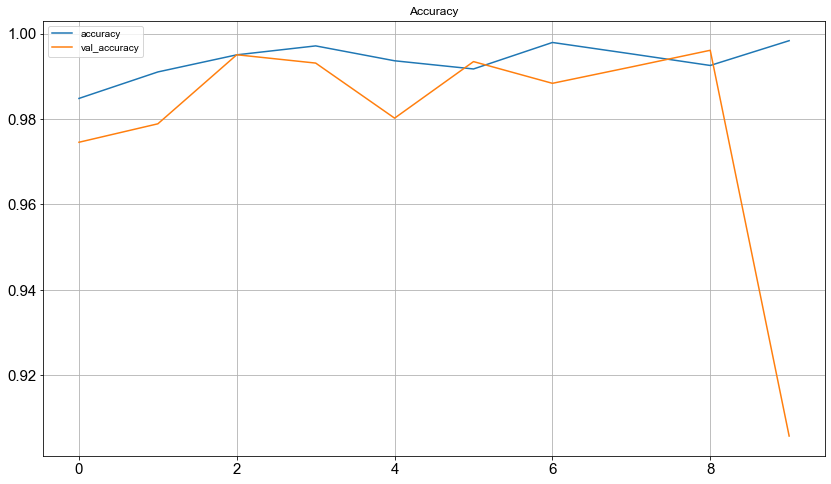

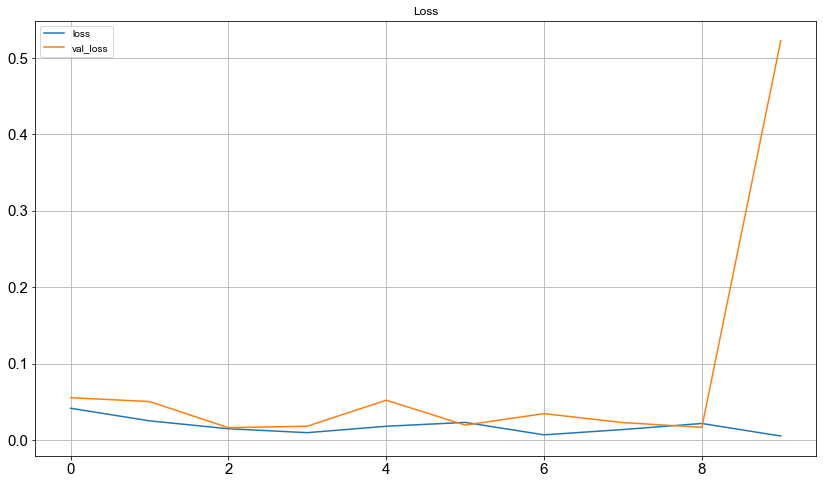

In [5]:
history_df[['accuracy','val_accuracy']].plot(figsize=(14,8),title='Accuracy',grid=True,fontsize=15)
history_df[['loss','val_loss']].plot(figsize=(14,8),title='Loss',grid=True,fontsize=15)